### **Expanded Momentum Model**
策略出處：

本策略源自Trading Evolved Ch12中的Expanded Momentum Model，核心理念在於找尋過去N天股價走勢穩定向上之個股，經由迴歸係數與決定係數($R^2$)給予加權分數，作為股票的主要篩選依據，接著計算該股票近K天的報酬率標準差，進行反向權重配置，意即波動太大之個股給予較小的持股比率，反之則給予較大的持股比率。

* 註：為避免太多運算造成計算過久，本範例以台灣50(0050)成分股為主要股票池

交易邏輯：

* 選股邏輯：

        計算股票過去N天的動能分數，篩選其中最高的M檔股票作為持股標的

* 配置邏輯：

        以股票近K天的報酬率計算標準差，進行反向權重配置

### Tejapi、Zipline、Pyfolio套件引入

In [1]:
import tejapi
import os
os.environ['TEJAPI_KEY'] = 'your key'
os.environ['TEJAPI_BASE'] = "https://api.tej.com.tw"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from zipline.pipeline import Pipeline
from zipline.pipeline.data import TWEquityPricing
from zipline.pipeline.factors import CustomFactor, AverageDollarVolume, SimpleMovingAverage, Returns
from zipline.master import get_prices, getToolData, tejquant, run_pipeline
from TejToolAPI.TejToolAPI import get_history_data

import warnings
warnings.filterwarnings('ignore')

In [2]:
from collections import defaultdict
from time import time

import numpy as np
import pandas as pd
import pandas_datareader.data as web
from logbook import Logger, StderrHandler, INFO

import matplotlib.pyplot as plt
import seaborn as sns

from zipline import run_algorithm
from zipline.api import (attach_pipeline,
                         pipeline_output,
                         order_target_percent, 
                         order_target_value,
                         symbol, 
                         set_commission, 
                         set_slippage, 
                         schedule_function, 
                         date_rules, 
                         time_rules, 
                         get_datetime, 
                         commission,
                         slippage,)
from zipline.data import bundles
from zipline.utils.run_algo import load_extensions
from zipline.utils.calendar_utils import get_calendar
from zipline.pipeline import Pipeline, CustomFactor
from zipline.pipeline.data import Column, DataSet, tejquant
from zipline.pipeline.domain import TW_EQUITIES
from zipline.pipeline.filters import StaticAssets
from zipline.pipeline.loaders.frame import DataFrameLoader

import pyfolio as pf
from pyfolio.plotting import plot_rolling_returns, plot_rolling_sharpe
from pyfolio.timeseries import forecast_cone_bootstrap

from scipy import stats  

In [3]:
sns.set_style('whitegrid')
pd.set_option('display.expand_frame_repr', False)
np.random.seed(42)

log_handler = StderrHandler(format_string='[{record.time:%Y-%m-%d %H:%M:%S.%f}]: ' +
                            '{record.level_name}: {record.func_name}: {record.message}',
                            level=INFO)
log_handler.push_application()
log = Logger('Algorithm')

#### 資料載入－Tejapi、TejToolAPI

* 擷取2015/01/01至2023/07/31所有上下市櫃公司股票代碼

In [4]:
from zipline.sources.TEJ_Api_Data import get_universe
start = '2015-01-01'
end = '2023-07-31'
pool = get_universe(start, end, mkt = ['TWSE', 'OTC'], stktp_e = ['Common Stock', 'Common Stock-Foreign'])

[2024-02-07 03:15:05.028343]: INFO: get_universe_TW: Filters：{'mkt': ['TWSE', 'OTC'], 'stktp_e': ['Common Stock', 'Common Stock-Foreign']}


Currently used TEJ API key call quota 360/9223372036854775807 (0.0%)
Currently used TEJ API key data quota 42790382/9223372036854775807 (0.0%)


* Ingest上述公司2015-01-01至2023-07-31的股價資料進bundle

In [5]:
os.environ['ticker'] = ' '.join(pool)

os.environ['mdate'] = '20150101 20230731'

!zipline ingest -b tquant

Merging daily equity files:
Currently used TEJ API key call quota 367/9223372036854775807 (0.0%)
Currently used TEJ API key data quota 53367944/9223372036854775807 (0.0%)


[2024-02-07 03:15:15.956712] INFO: zipline.data.bundles.core: Ingesting tquant.
[2024-02-07 03:19:18.844659] INFO: zipline.data.bundles.core: Ingest tquant successfully.


* 使用get_history_data載入上述公司同期間之台灣50成分股標記

In [6]:
fg0050 = get_history_data(ticker=pool, columns=['Component_Stock_of_TWN50_Fg'], start='2015-01-01', end='2023-07-31')

Currently used TEJ API key call quota 475/9223372036854775807 (0.0%)
Currently used TEJ API key data quota 59946597/9223372036854775807 (0.0%)


In [7]:
fg0050['Component_Stock_of_TWN50_Fg'] = fg0050['Component_Stock_of_TWN50_Fg'].replace({'Y': 1, '': 0})

fg0050 = fg0050.sort_values(['coid', 'mdate'])

* 將載入後的資料轉換成Zipline所需格式

In [8]:
def Custom_loader(df, bundle):

    df['coid'] = df['coid'].astype(str)
    
    column = df.columns[~df.columns.isin(['coid', 'mdate'])].tolist()

    sids = bundle.asset_finder.equities_sids
    assets = bundle.asset_finder.retrieve_all(sids)
    symbols = [i.symbol for i in assets] 

    target_symbols = df[df['coid'].isin(symbols)]['coid'].unique().tolist()

    assets = bundle.asset_finder.lookup_symbols(target_symbols, as_of_date=None)
    assets_map = {i.symbol: i for i in assets}

    baseline_data = {}

    df1 = df.set_index(['coid', 'mdate'])
    for i in column:
        target = df1.unstack('coid')[i][target_symbols]
        target.columns = target.columns.map(assets_map)
        target = target.tz_localize('UTC').tz_convert('UTC')
        baseline_data.update({i: target})

    return baseline_data

In [9]:
bundle = bundles.load('tquant')

baseline_data = Custom_loader(fg0050, bundle)

In [10]:
baseline_data['Component_Stock_of_TWN50_Fg']

coid,Equity(0 [1101]),Equity(1 [1102]),Equity(2 [1103]),Equity(3 [1104]),Equity(4 [1108]),Equity(5 [1109]),Equity(6 [1110]),Equity(7 [1201]),Equity(8 [1203]),Equity(9 [1210]),...,Equity(1903 [9944]),Equity(1904 [9945]),Equity(1905 [9946]),Equity(1906 [9949]),Equity(1907 [9950]),Equity(1908 [9951]),Equity(1909 [9955]),Equity(1910 [9958]),Equity(1911 [9960]),Equity(1912 [9962])
mdate,,,,,,,,,,,,,,,,,,,,,
2015-01-05 00:00:00+00:00,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-06 00:00:00+00:00,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-07 00:00:00+00:00,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-08 00:00:00+00:00,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-09 00:00:00+00:00,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-25 00:00:00+00:00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-07-26 00:00:00+00:00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-07-27 00:00:00+00:00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
class CustomDataset(DataSet):
    fg = Column(dtype=float)

    domain = TW_EQUITIES     
    
transform_data = {CustomDataset.fg: DataFrameLoader(CustomDataset.fg, baseline_data['Component_Stock_of_TWN50_Fg'])}

transform_data

{CustomDataset<TW>.fg::float64: <zipline.pipeline.loaders.frame.DataFrameLoader at 0x22b27006590>}

### Pipeline－動能因子計算

* 動能分數計算

In [12]:
def momentum_score(ts):

    x = np.arange(len(ts)) 

    log_ts = np.log(ts) 

    slope, intercept, r_value, p_value, std_err = stats.linregress(x, log_ts)

    annualized_slope = (np.power(np.exp(slope), 252) - 1) * 100

    score = annualized_slope * (r_value ** 2)
    
    return score

* 設定為0050成分股才可以計算動能分數

In [13]:
class factor_momentum_score(CustomFactor):

    inputs = [TWEquityPricing.close, CustomDataset.fg]

    def compute(self, today, assets, out, close, fg):

        close, fg = pd.DataFrame(close), pd.DataFrame(fg)

        target_stock = fg.iloc[-1][fg.iloc[-1].eq(1)].index
        
        out[:] = [momentum_score(close[i]) if i in target_stock else np.nan for i in close]

* 計算週期：近20天收盤價

* 篩選標準：
  * 篩選出動能分數大於0
  * 動能分數大於全體動能分數中位數的個股

In [14]:
def make_pipeline():

    mom_signals = factor_momentum_score(window_length=20)

    close = TWEquityPricing.close.latest

    pipe = Pipeline(
        columns={
            'mom_score': mom_signals,
            
            'close':close,
        },
        screen=(mom_signals > 0) & (mom_signals > mom_signals.median())
    )
    return pipe

In [15]:
start_dt = pd.Timestamp('2015-01-01', tz='utc')
end_dt = pd.Timestamp('2023-07-31', tz='utc')

from zipline.data import bundles

bundle = bundles.load('tquant')

from zipline.pipeline.loaders import EquityPricingLoader

pricing_loader = EquityPricingLoader.without_fx(bundle.equity_daily_bar_reader, bundle.adjustment_reader)

def choose_loader(column):
    if column in TWEquityPricing.columns:
        return pricing_loader
    return transform_data[column]

from zipline.pipeline.engine import SimplePipelineEngine

engine = SimplePipelineEngine(get_loader=choose_loader,
                              asset_finder=bundle.asset_finder,
                              )

pipe = make_pipeline()
data = engine.run_pipeline(pipe, start_dt, end_dt)
data.dropna(axis=0)

mom_score   close
2015-02-02 00:00:00+00:00 Equity(12 [1216])     104.782181   50.50
                          Equity(33 [1301])     232.346669   76.50
                          Equity(34 [1303])      38.095884   63.50
                          Equity(51 [1326])     205.992225   67.80
                          Equity(60 [1402])      49.745482   31.80
...                                                    ...     ...
2023-07-31 00:00:00+00:00 Equity(627 [3037])   1120.226598  191.00
                          Equity(923 [3711])     35.451410  117.50
                          Equity(1113 [4938])   274.023578   78.70
                          Equity(1305 [5880])    37.012132   29.25
                          Equity(1877 [9910])   167.402697  212.00

[42846 rows x 2 columns]

### Zipline－策略回測
  
* 設定固定滑價成本和交易手續費各為0.2%
  
* 月初進場邏輯：每天買進股票池中符合條件之個股，使用反向波動度進行加權配置
  
* 月底出場邏輯：若投組內個股在月底並不在待交易清單內則出清

In [16]:
def initialize1(context):

    set_slippage(slippage.FixedSlippage(spread=0.002))
    set_commission(commission.PerDollar(cost=0.002))
    

    schedule_function(
        func=rebalance_start,
        date_rule=date_rules.month_start(),
        time_rule=time_rules.market_open()
    )

    schedule_function(
        func=rebalance_end,
        date_rule=date_rules.month_end(),
        time_rule=time_rules.market_open()
    )
    
    pipeline = make_pipeline()
    attach_pipeline(pipeline, 'make_pipeline')

def before_trading_start(context, data):

    context.trades = pipeline_output('make_pipeline')
    
def rebalance_start(context, data):

    if len(context.trades) != 0:

        target = context.trades
        
        for stock in target.index:

            if data.can_trade(stock):
                
                hist_vol = data.history(stock, "close", 120, "1d").pct_change().rolling(20).std().iloc[-1]

                target.loc[stock, 'pos'] = 1 / hist_vol

        for stock, pos in zip(target.index, target.pos):

            if stock not in context.portfolio.positions.keys():

                order_value = (pos / target.pos.sum()) * context.portfolio.cash

                order_target_value(stock, order_value)

def rebalance_end(context, data):

    if len(context.trades) != 0:

        target = context.trades
                
        for stock in list(context.portfolio.positions.keys()):

            if stock not in target.index:

                order_target_value(stock, 0)


def portfolio_plot(context, results):
    import matplotlib.pyplot as plt
    import logbook
    logbook.StderrHandler().push_application()
    log = logbook.Logger('Algorithm')

    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    results['benchmark_cum'] = results.benchmark_return.add(1).cumprod()*1000000

    results[['portfolio_value', 'benchmark_cum']].plot(ax=ax1, label='Portfolio Value($)')

    ax1.set_ylabel('Portfolio value (TWD)')

    plt.legend(loc='upper left')

    plt.gcf().set_size_inches(18, 8)
    plt.show()

Currently used TEJ API key call quota 488/9223372036854775807 (0.0%)
Currently used TEJ API key data quota 61085453/9223372036854775807 (0.0%)


[2024-02-07 03:20:33.168941]: INFO: earn_dividends: Equity(563 [2883]), cash_dividend amount: 0.6, pay_date: 2015-07-24, div_owed: 1485.6
[2024-02-07 03:20:33.189113]: INFO: earn_dividends: Equity(1872 [9904]), cash_dividend amount: 1.5, pay_date: 2015-08-05, div_owed: 1432.5
[2024-02-07 03:20:33.239701]: INFO: earn_dividends: Equity(417 [2454]), cash_dividend amount: 21.99993374, pay_date: 2015-08-07, div_owed: 2243.99324148
[2024-02-07 03:20:33.239701]: INFO: earn_dividends: Equity(1094 [4904]), cash_dividend amount: 3.75, pay_date: 2015-08-07, div_owed: 1485.0
[2024-02-07 03:20:33.249983]: INFO: earn_dividends: Equity(383 [2412]), cash_dividend amount: 4.8564, pay_date: 2015-08-27, div_owed: 2981.8296
[2024-02-07 03:20:33.299203]: INFO: earn_dividends: Equity(323 [2325]), cash_dividend amount: 3.0, pay_date: 2015-08-21, div_owed: 3318.0
[2024-02-07 03:20:34.892291]: INFO: earn_dividends: Equity(572 [2892]), cash_dividend amount: 0.7, pay_date: 2015-08-20, div_owed: 2695.7
[2024-02-0

[2024-02-07 03:20:46.157870]: INFO: earn_dividends: Equity(33 [1301]), cash_dividend amount: 4.6, pay_date: 2017-08-09, div_owed: 1642.1999999999998
[2024-02-07 03:20:46.157870]: INFO: earn_dividends: Equity(1094 [4904]), cash_dividend amount: 3.75, pay_date: 2017-08-04, div_owed: 1908.75
[2024-02-07 03:20:46.157870]: INFO: earn_dividends: Equity(319 [2317]), cash_dividend amount: 4.5, pay_date: 2017-08-10, div_owed: 1602.0
[2024-02-07 03:20:46.157870]: INFO: earn_dividends: Equity(342 [2354]), cash_dividend amount: 3.8, pay_date: 2017-08-10, div_owed: 581.4
[2024-02-07 03:20:46.187242]: INFO: earn_dividends: Equity(571 [2891]), cash_dividend amount: 1.0, pay_date: 2017-08-11, div_owed: 1155.0
[2024-02-07 03:20:46.203087]: INFO: earn_dividends: Equity(34 [1303]), cash_dividend amount: 4.5, pay_date: 2017-08-11, div_owed: 2011.5
[2024-02-07 03:20:46.242384]: INFO: earn_dividends: Equity(283 [2105]), cash_dividend amount: 3.0, pay_date: 2017-08-25, div_owed: 1179.0
[2024-02-07 03:20:46.2

[2024-02-07 03:20:58.451759]: INFO: earn_dividends: Equity(60 [1402]), cash_dividend amount: 1.8, pay_date: 2019-08-16, div_owed: 2649.6
[2024-02-07 03:20:58.473942]: INFO: earn_dividends: Equity(1 [1102]), cash_dividend amount: 2.8, pay_date: 2019-08-16, div_owed: 1282.3999999999999
[2024-02-07 03:20:58.489624]: INFO: earn_dividends: Equity(241 [2002]), cash_dividend amount: 1.0, pay_date: 2019-08-27, div_owed: 3241.0
[2024-02-07 03:20:58.489624]: INFO: earn_dividends: Equity(319 [2317]), cash_dividend amount: 4.0, pay_date: 2019-08-23, div_owed: 1712.0
[2024-02-07 03:20:58.505196]: INFO: earn_dividends: Equity(365 [2382]), cash_dividend amount: 3.55, pay_date: 2019-08-23, div_owed: 2502.75
[2024-02-07 03:20:58.536442]: INFO: earn_dividends: Equity(1113 [4938]), cash_dividend amount: 3.50089644, pay_date: 2019-08-23, div_owed: 2083.0333818
[2024-02-07 03:20:58.536442]: INFO: earn_dividends: Equity(1302 [5871]), cash_dividend amount: 4.2, pay_date: 2019-08-30, div_owed: 730.80000000000

[2024-02-07 03:21:05.613424]: INFO: earn_dividends: Equity(566 [2886]), cash_dividend amount: 1.7, pay_date: 2020-09-04, div_owed: 6143.8
[2024-02-07 03:21:05.613424]: INFO: earn_dividends: Equity(923 [3711]), cash_dividend amount: 1.99802982, pay_date: 2020-09-10, div_owed: 743.26709304
[2024-02-07 03:21:05.629049]: INFO: handle_split: after split: asset: Equity(565 [2885]), amount: 1829, cost_basis: 17.0, last_sale_price: 19.1
[2024-02-07 03:21:05.629049]: INFO: handle_split: returning cash: 15.22
[2024-02-07 03:21:05.644674]: INFO: earn_dividends: Equity(1877 [9910]), cash_dividend amount: 4.0, pay_date: 2020-09-16, div_owed: 1080.0
[2024-02-07 03:21:05.644674]: INFO: handle_split: after split: asset: Equity(1877 [9910]), amount: 324, cost_basis: 151.97, last_sale_price: 199.0
[2024-02-07 03:21:05.644674]: INFO: handle_split: returning cash: 0.0
[2024-02-07 03:21:05.918175]: INFO: earn_dividends: Equity(327 [2330]), cash_dividend amount: 2.5, pay_date: 2020-10-15, div_owed: 282.5
[2

[2024-02-07 03:21:17.878816]: INFO: earn_dividends: Equity(383 [2412]), cash_dividend amount: 4.608, pay_date: 2022-08-05, div_owed: 2856.9599999999996
[2024-02-07 03:21:17.878816]: INFO: earn_dividends: Equity(1824 [8454]), cash_dividend amount: 13.0, pay_date: 2022-07-29, div_owed: 234.0
[2024-02-07 03:21:17.878816]: INFO: handle_split: after split: asset: Equity(1824 [8454]), amount: 21, cost_basis: 642.12, last_sale_price: 763.0
[2024-02-07 03:21:17.878816]: INFO: handle_split: returning cash: 385.28
[2024-02-07 03:21:17.979273]: INFO: earn_dividends: Equity(33 [1301]), cash_dividend amount: 8.2, pay_date: 2022-08-05, div_owed: 3238.9999999999995
[2024-02-07 03:21:17.989521]: INFO: earn_dividends: Equity(1303 [5876]), cash_dividend amount: 1.8, pay_date: 2022-07-26, div_owed: 975.6
[2024-02-07 03:21:18.001798]: INFO: earn_dividends: Equity(293 [2207]), cash_dividend amount: 20.0, pay_date: 2022-07-27, div_owed: 1360.0
[2024-02-07 03:21:18.001798]: INFO: earn_dividends: Equity(634 [

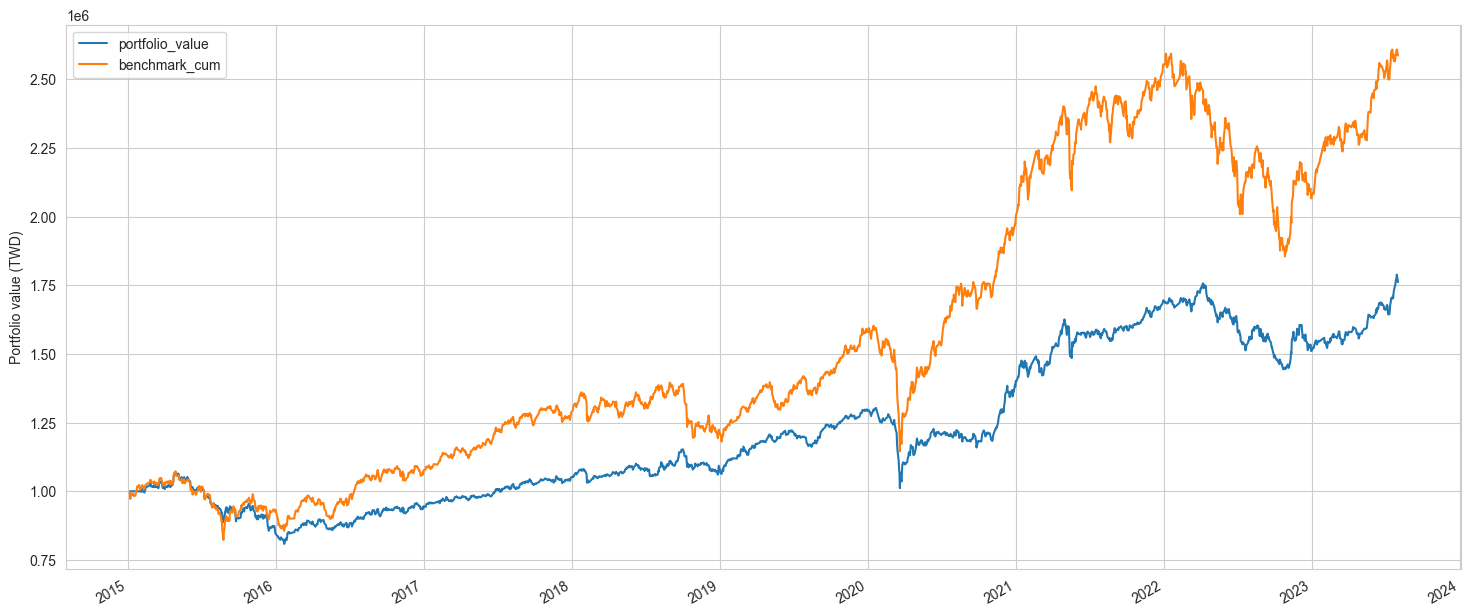

In [17]:
start_dt = pd.Timestamp('2015-01-01', tz='utc')
end_dt = pd.Timestamp('2023-07-31', tz='utc')

from zipline.sources.TEJ_Api_Data import (get_Treasury_Return,
                                          get_Benchmark_Return,
                                          )

Bindex=get_Benchmark_Return(start=start_dt,
                     end=end_dt,
                     symbol='IR0001').sort_index(ascending=True).tz_convert('utc')

results = run_algorithm(start=start_dt,  
                       end=end_dt,
                       initialize=initialize1,
                       before_trading_start=before_trading_start,
                       capital_base=1e6,
                       benchmark_returns=Bindex,
                       data_frequency='daily',
                       bundle='tquant',
                       custom_loader=transform_data,
                       analyze=portfolio_plot) 

### Pyfolio－投組績效分析

In [18]:
from pyfolio.utils import extract_rets_pos_txn_from_zipline, print_table
returns, positions, transactions = extract_rets_pos_txn_from_zipline(results)

returns.index = returns.index.tz_localize(None).tz_localize('UTC')
positions.index = positions.index.tz_localize(None).tz_localize('UTC')
transactions.index = transactions.index.tz_localize(None).tz_localize('UTC')
results.benchmark_return.index = results.benchmark_return.index.tz_localize(None).tz_localize('UTC')

from pyfolio.plotting import show_perf_stats
perf_stats = show_perf_stats(returns=returns,
                factor_returns=results.benchmark_return,
                positions=positions,
                transactions=transactions,
                live_start_date='2022-01-01',
                )

Start date,2015-01-05
End date,2023-07-31
Total months,99
,Backtest
Annual return,7.056%
Cumulative returns,76.12%
Annual volatility,10.806%
Sharpe ratio,0.69
Calmar ratio,0.29
Stability,0.88
Max drawdown,-24.552%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,24.55,2015-04-28,2016-01-21,2018-01-16,673
1,22.40,2020-01-20,2020-03-19,2020-12-01,211
2,17.82,2022-04-06,2022-10-21,2023-07-25,319
3,8.66,2021-04-29,2021-05-17,2021-11-09,134
4,7.97,2018-10-01,2018-12-26,2019-02-21,95


Stress Events,mean,min,max
Fall2015,-0.12%,-2.81%,2.37%
New Normal,0.03%,-5.00%,5.52%


Top 10 long positions of all time,max
sid,
2325,66.88%
4938,41.89%
1216,30.89%
4904,29.25%
3045,22.37%
5876,21.96%
2412,18.01%
2912,16.66%
2357,16.58%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
2325,66.88%
4938,41.89%
1216,30.89%
4904,29.25%
3045,22.37%
5876,21.96%
2412,18.01%
2912,16.66%
2357,16.58%


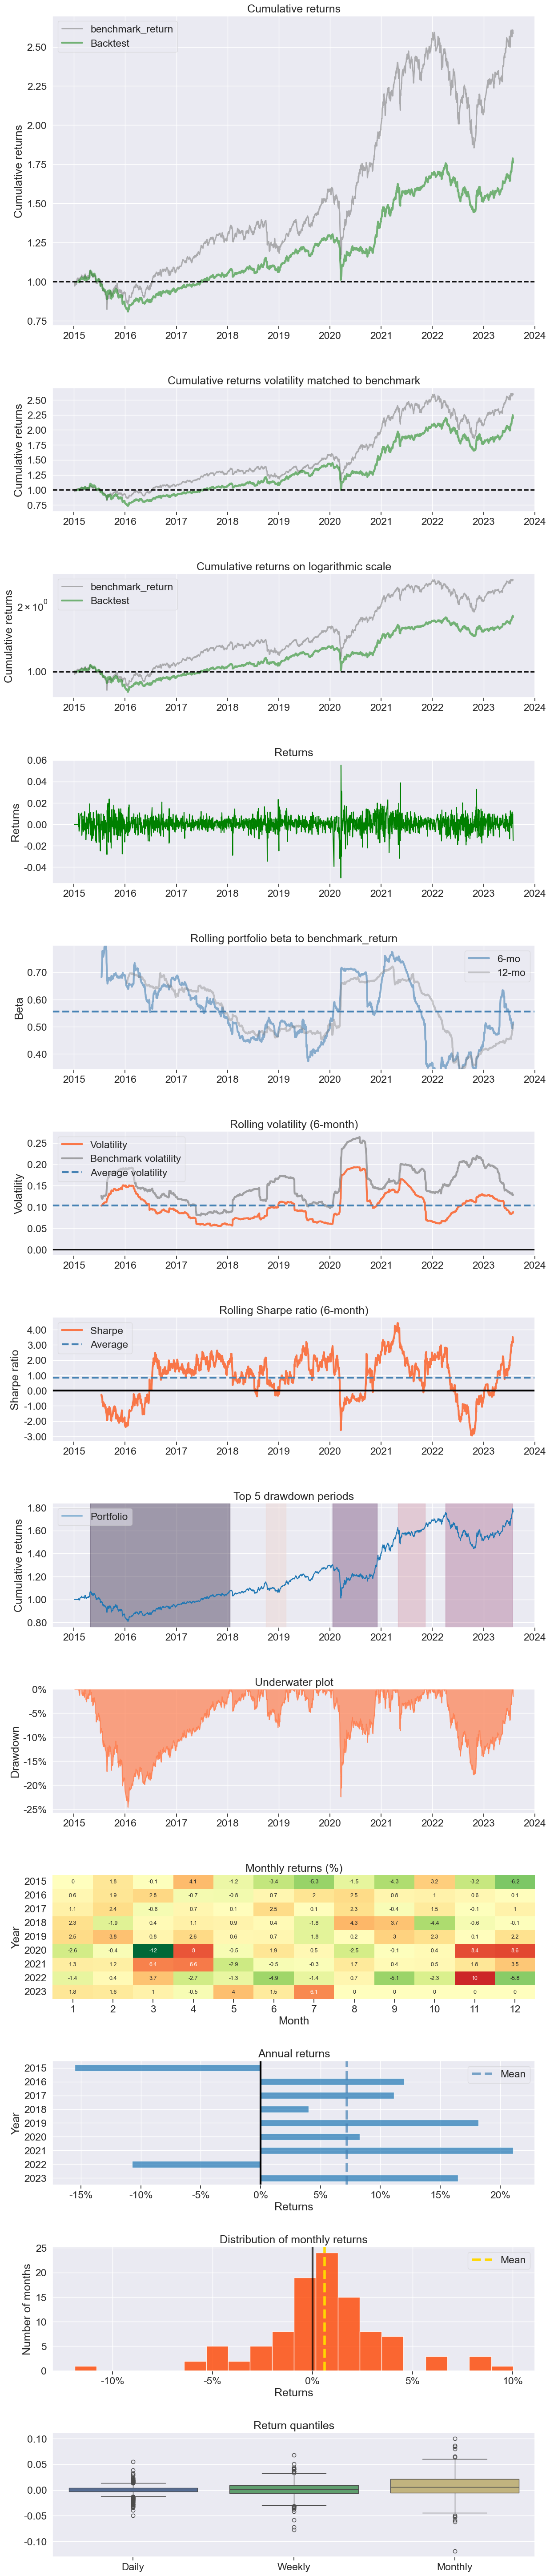

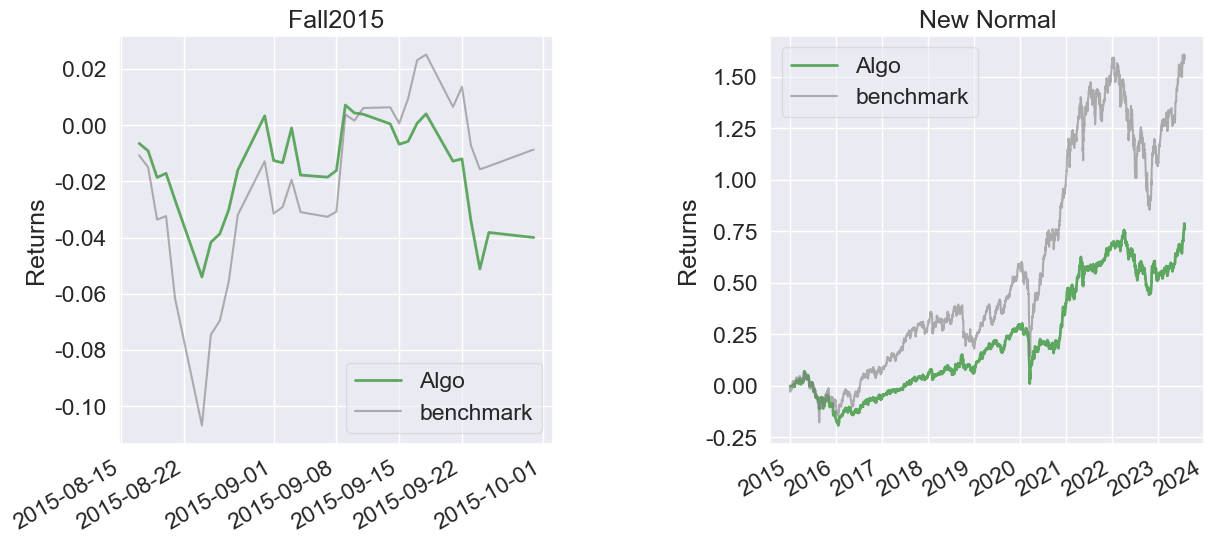

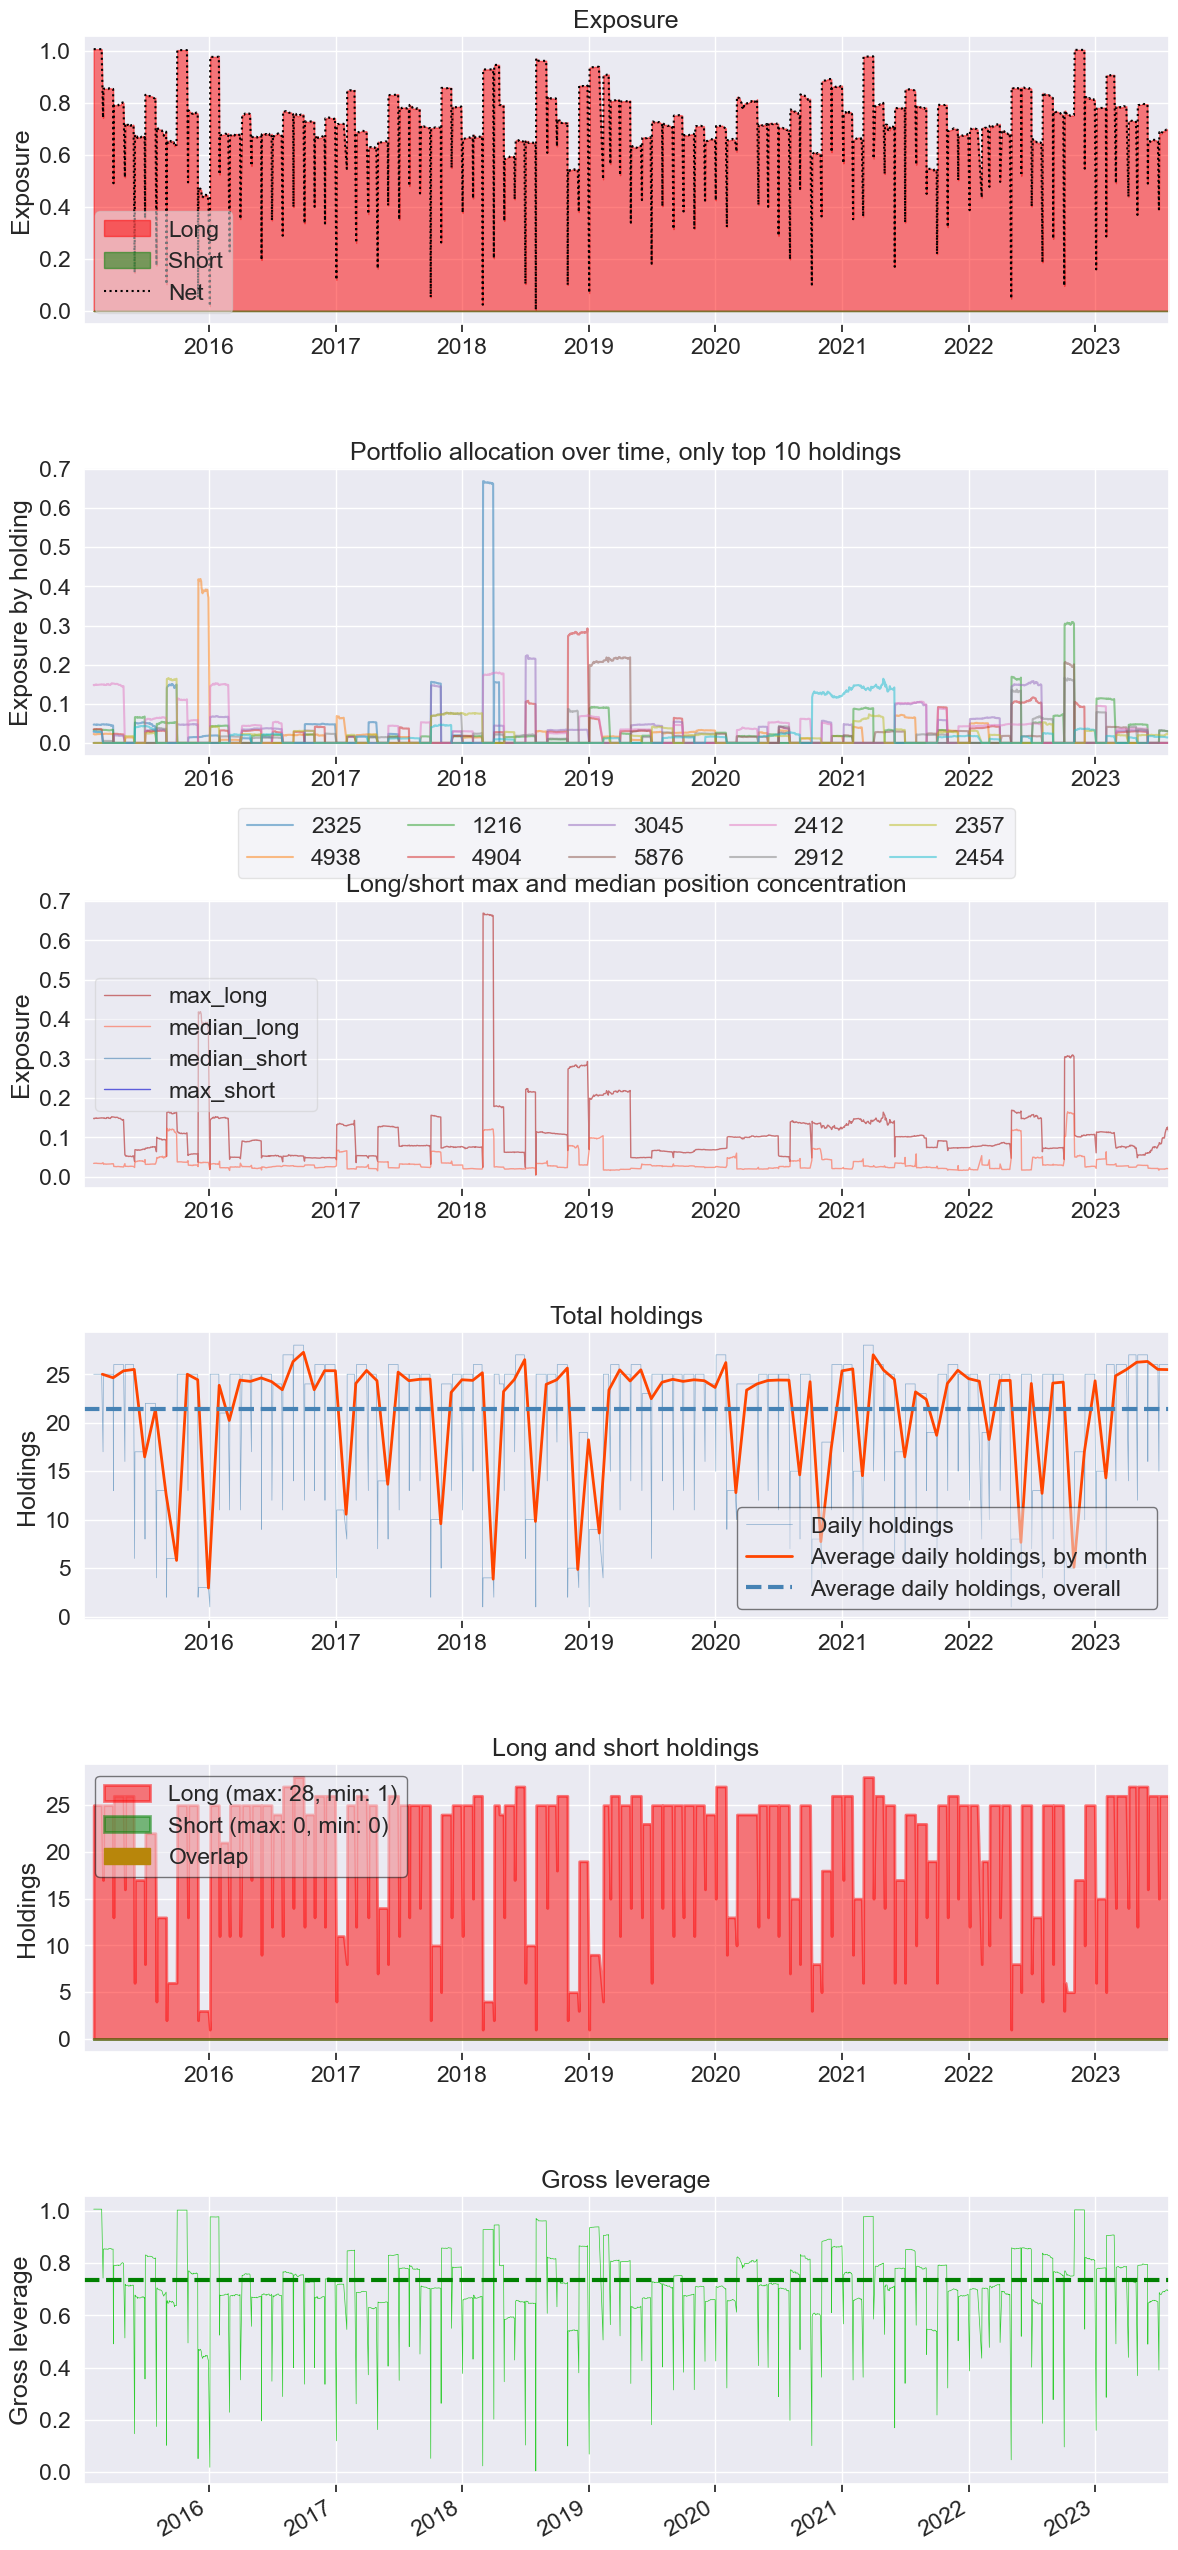

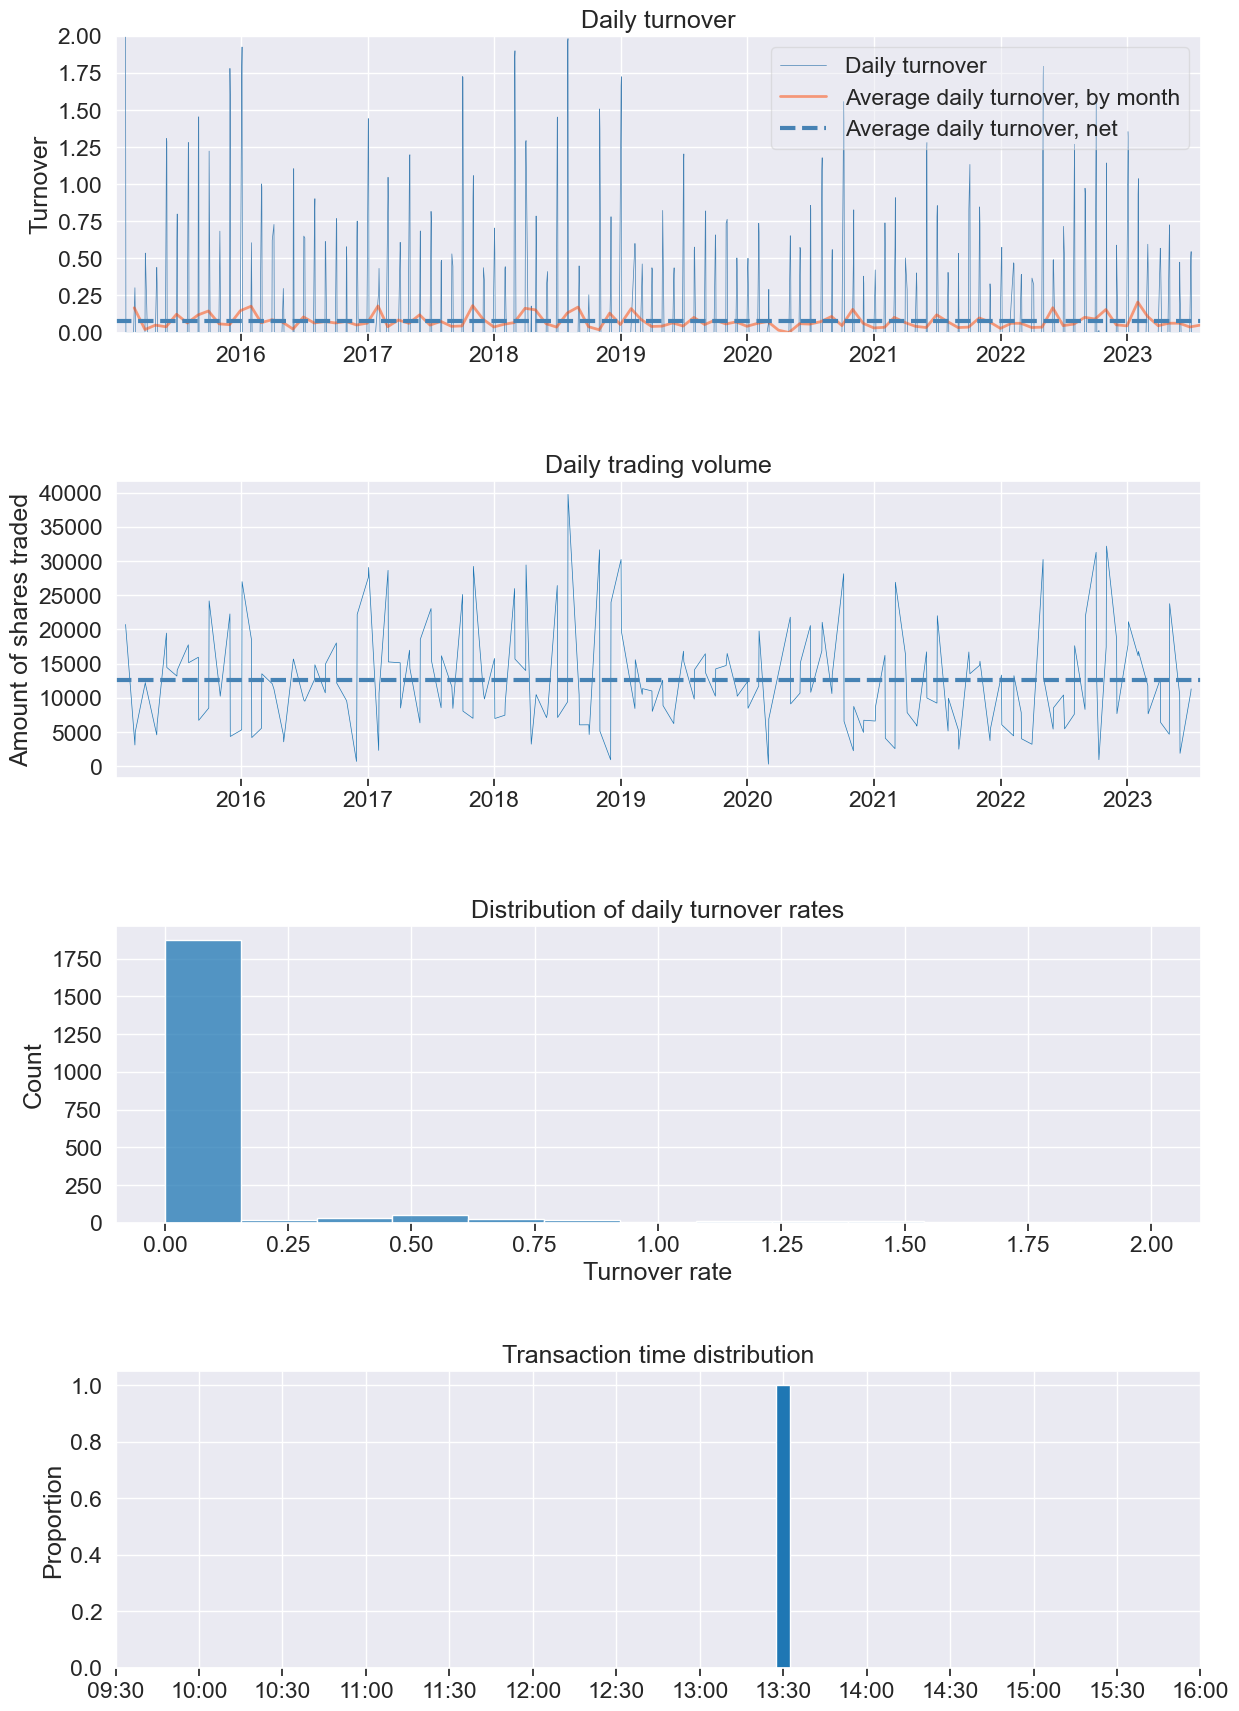

In [19]:
pf.create_full_tear_sheet(returns, positions, transactions, benchmark_rets=results.benchmark_return)